# VaR & CVaR Calculation (4th Project)
Value At Risk estimates & analysis to help us manage risk

## Import Modules

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## Load Data
Data is downloaded and added to dataframe

In [ ]:
def loadData(ticker="MSFT", start="2023-01-01", end="2024-01-01"):
    data = yf.download(ticker, start, end)
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.droplevel(1)

    if 'Close' not in data.columns:
        print("Error: 'Close' column is missing. Check the ticker symbol.")
        print(data.head())
        return None

    data = data[["Close"]]
    returns = data.pct_change().dropna()

    return returns, ticker

## VaR
Returns are estimated using historical, parametric, and Monte Carlo simulations and the appropriate confidence level

In [ ]:
def historicalVar(returns, confidence=0.95):
    """
    percentile of historical returns
    """
    var = -np.percentile(returns, (1 - confidence) * 100)
    return var

def parametricVar(returns, confidence=0.95):
    """
    VaR just assuming normal distribution of returns
    """
    mu = returns.mean()
    sigma = returns.std()
    z = norm.ppf(1 - confidence)
    var = -(mu + z * sigma)
    return var.iloc[0] # Return the scalar value

def monteCarloVar(returns, confidence=0.95, simulations=10000):
    """
    simulate returns from normal distribution with estimated mean and std, then find percentile loss
    """
    mu = returns.mean()
    sigma = returns.std()
    simulatedReturns = np.random.normal(mu, sigma, simulations)
    var = -np.percentile(simulatedReturns, (1 - confidence) * 100)
    return var, simulatedReturns

## CVaR
CVaR estimates how much is at risk beyond the confidence level.

This is patches an important weakness of the VaR otherwise; to consider potential losses in worst-case scenarios.

In [ ]:
def calculateMonteCarloCVaR(returns, var):
    """
    Avg loss beyond VaR confidence
    """
    cvar = returns[returns <= -var].mean()
    return cvar.iloc[0] if isinstance(cvar, pd.Series) else cvar

def backtestVaR(returns, var, confidence, window=100):
    """
    Backtesting strategy to see how often losses actually exceed VaR
    """
    expectedToExceed = 1-confidence
    if window > len(returns):
        print("Warning: Window size for backtesting is larger than the number of returns. Adjusting window size.")
        window = len(returns)
    actualExceed = returns.rolling(window=window).apply(lambda x: (x <= -var).mean(), raw=True)
    return actualExceed.mean().iloc[0] - expectedToExceed if isinstance(actualExceed.mean(), pd.Series) else actualExceed.mean() - expectedToExceed

## Graph
Estimated and simulated returns are visualised

In [ ]:
def graph(returns, simulatedReturns, histVar, mcVar, confidence, ticker):
    plt.figure(figsize=(12,6))
    plt.hist(returns, bins=50, alpha=0.5, label="Historical Returns")
    plt.hist(simulatedReturns, bins=50, alpha=0.5, label="Monte Carlo Simulated Returns")

    plt.axvline(-histVar, color='red', linestyle='dashed', linewidth=2, label=f"Historical VaR ({confidence*100:.0f}%)")
    plt.axvline(-mcVar, color='green', linestyle='dashed', linewidth=2, label=f"Monte Carlo VaR ({confidence*100:.0f}%)")

    plt.title(f"Return Distributions & VaR - {ticker}")
    plt.xlabel("Returns")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

/tmp/ipython-input-1259318465.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start, end)
[*********************100%***********************]  1 of 1 completed


VaR at 95% confidence level for MSFT:
 - Historical VaR: 0.0229, CVaR: -0.0292, Backtest diff: 0.0007
 - Parametric VaR: 0.0241
 - Monte Carlo VaR: 0.0247, CVaR: -0.0312, Backtest diff: -0.0122


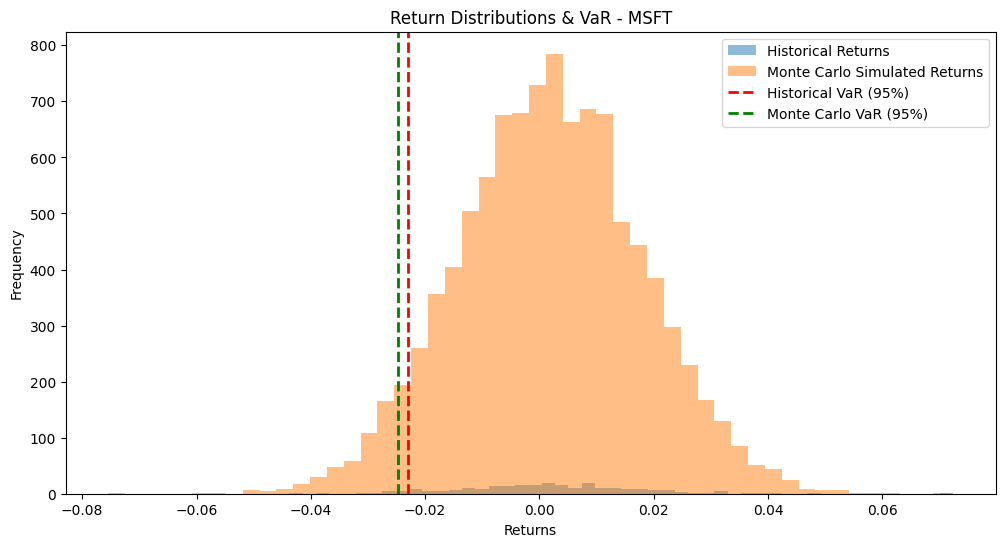

In [ ]:
def main():
    ticker = "MSFT"
    start = "2023-01-01"
    end = "2024-01-01"
    confidence = 0.95

    returns, ticker = loadData(ticker, start, end)

    # VaR & simulated returns calculated
    histVar = historicalVar(returns, confidence)
    paramVar = parametricVar(returns, confidence)
    mcVar, simulatedReturns = monteCarloVar(returns, confidence)

    # CVaR calculations
    cvarHist = calculateMonteCarloCVaR(returns, histVar)
    cvarMC = calculateMonteCarloCVaR(pd.Series(simulatedReturns), mcVar)

    # backtests
    backtestHist = backtestVaR(returns, histVar, confidence)
    backtestMC = backtestVaR(returns, mcVar, confidence)

    # results
    print(f"VaR at {confidence*100:.0f}% confidence level for {ticker}:")
    print(f" - Historical VaR: {histVar:.4f}, CVaR: {cvarHist:.4f}, Backtest diff: {backtestHist:.4f}")
    print(f" - Parametric VaR: {paramVar:.4f}")
    print(f" - Monte Carlo VaR: {mcVar:.4f}, CVaR: {cvarMC:.4f}, Backtest diff: {backtestMC:.4f}")

    graph(returns, simulatedReturns, histVar, mcVar, confidence, ticker)

if __name__ == "__main__":
    main()

## Conclusion / Evaluation
My fourth project